## Wind Turbine Power Output Prediction

# Regression Analysis

**Motivation**

In this work, various Regression Analyses are performed to predict power output of a wind turbine for a **Kaggle Competition** is performed. The results are evaluated with Root Mean Squared Error (RMSE) score. To improve this score many **state-of-art regression algorithms** are utilized, as well as, various **novel imputation techniques**. This work contains all the processes from data cleaning to machine learning. 

**Dataset**

The data set presented in the problem consists of real-time SCADA data. In the shared data set, the real-time power generation amount (Power(kW)) of a wind turbine on a 10-minute basis between 01.01.2019 and 14.08.2021 is given. In addition to real-time power generation; some SCADA data of the wind turbine were shared for the date range 01.01.2019 – 14.12.2021. The date range to be estimated has been determined as 15.08.2021 – 14.12.2021.

**RoadMap**

<li>We begin our work by importing libraries and dataset. 
<li>After data cleaning, analysis and missing value analysis, we will try to impute missing values with <b>KNNImputer, SimpleImputer, IterativeImputer</b> and <b>LGBM Imputer</b>. 
<li>When data is split into train and test dataframes, <b>StratifiedKFold</b> algorithm is chosen instead of simple train_test_split method, which randomly selects sample values. The reason for that is to maintain distribution of the data to get better results with ML.
<li>Then, we will apply various regression algoritms, e.g., <b>ElasticNet, KNN Regressor, SVM, MLP Regressor (Neural Network), Decision Tree, Bagging, RandomForest, ADABoost, GradientBoosting, XGBoost, LGBM</b> and <b>CatBoost Regressors</b>. 
<li>Based on their results, the best performing imputer will be selected and the best performing regressors will be tuned to improve our score.

<br><br>

## 1. Importing Libraries & Raw Data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [3]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer, SimpleImputer, IterativeImputer
from tqdm import tqdm
import lightgbm as lgb

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

In [4]:
features = pd.read_csv("features.csv")

In [5]:
power = pd.read_csv("power.csv")

In [6]:
units = pd.read_csv("feature_units.csv")

<br><br><br>

## 2. Exploratory Data Analysis

In [7]:
features.head()

,Timestamp,Gearbox_T1_High_Speed_Shaft_Temperature,Gearbox_T3_High_Speed_Shaft_Temperature,Gearbox_T1_Intermediate_Speed_Shaft_Temperature,Temperature Gearbox Bearing Hollow Shaft,Tower Acceleration Normal,Gearbox_Oil-2_Temperature,Tower Acceleration Lateral,Temperature Bearing_A,Temperature Trafo-3,...,Blade-1 Actual Value_Angle-A,Blade-2 Set Value_Degree,Pitch Demand Baseline_Degree,Blade-1 Set Value_Degree,Blade-3 Set Value_Degree,Moment Q Direction,Moment Q Filltered,Proxy Sensor_Degree-45,Turbine State,Proxy Sensor_Degree-315
0,2019-01-01 00:00:00,57.000000,59.000000,52.000000,56.158333,47.053776,57.000000,18.890772,35.000000,48.576668,...,0.055473,0.267122,0.0,0.058617,-0.325738,37.867054,39.281124,5.732657,1.0,5.779913
1,2019-01-01 00:10:00,57.693333,59.485001,52.450001,57.000000,64.969742,57.413334,28.560265,35.233334,48.000000,...,0.055473,0.267122,0.0,0.058617,-0.325738,-90.169106,-89.018669,5.813177,1.0,5.796757
2,2019-01-01 00:20:00,59.000000,60.756668,53.536667,57.775002,51.149670,58.728333,34.228813,36.000000,48.053333,...,0.055473,0.267122,0.0,0.058617,-0.325738,-88.556343,-88.422020,5.786413,1.0,5.772958
3,2019-01-01 00:30:00,59.881668,61.563332,54.413334,58.683334,58.740929,59.518333,35.593220,36.000000,48.788334,...,0.055473,0.267122,0.0,0.058617,-0.325738,-123.755341,-124.858444,5.758913,1.0,5.728393
4,2019-01-01 00:40:00,61.290001,62.586666,55.485001,59.623333,53.264774,60.665001,38.552731,36.000000,49.000000,...,0.053982,0.267612,0.0,0.058703,-0.325443,-142.533325,-142.053543,5.724591,1.0,5.687730


In [8]:
power.head()

,Timestamp,Power(kW)
0,2019-01-01 00:00:00,705.876648
1,2019-01-01 00:10:00,884.711670
2,2019-01-01 00:20:00,982.875000
3,2019-01-01 00:30:00,1115.943359
4,2019-01-01 00:40:00,1263.841675


In [9]:
units[10:20]

,Column,Unit
10,Gearbox_T3_Intermediate_Speed_Shaft_Temperature,(°C)
11,Gearbox_Oil-1_Temperature,(°C)
12,Gearbox_Oil_Temperature,(°C)
13,Torque,(%)
14,Converter Control Unit Reactive Power,(kVAr)
15,Temperature Trafo-2,(°C)
16,Reactive Power,(kVAr)
17,Temperature Shaft Bearing-1,(°C)
18,Gearbox_Distributor_Temperature,(°C)
19,Moment D Filtered,(kNm)


In [10]:
features.describe().T.iloc[60:]

,count,mean,std,min,25%,50%,75%,max
Proxy Sensor_Degree-135,148925.0,837.790402,9082.580653,-0.238800,5.858970,5.886291,5.914281,99999.0
State and Fault,150238.0,919.287000,9473.926246,1.000000,2.000000,2.000000,2.000000,99999.0
Proxy Sensor_Degree-225,149432.0,852.375004,9161.127074,-0.238800,5.860705,5.897005,5.932630,99999.0
Blade-3 Actual Value_Angle-A,149439.0,831.673642,9015.617418,-408.779999,-0.694006,0.029834,10.062227,99999.0
Scope CH 4,149786.0,837.293043,9045.244996,-408.779999,-0.694079,0.030175,10.212331,99999.0
Blade-2 Actual Value_Angle-A,150291.0,839.500329,9051.777608,-408.779999,0.650428,1.276868,11.359533,99999.0
Blade-1 Actual Value_Angle-A,149468.0,956.675567,9668.807744,-408.779999,0.075942,0.758596,10.780817,99999.0
Blade-2 Set Value_Degree,149831.0,882.596231,9280.006707,-0.128618,0.652857,1.245257,11.465339,99999.0
Pitch Demand Baseline_Degree,149074.0,934.692157,9554.834159,0.000000,0.000000,0.681229,10.788655,99999.0
Blade-1 Set Value_Degree,148756.0,873.612534,9234.898677,-0.766988,0.078384,0.830161,10.965823,99999.0


In [11]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 154262 entries, 0 to 154261
Data columns (total 77 columns):
 #   Column                                             Non-Null Count   Dtype  
---  ------                                             --------------   -----  
 0   Timestamp                                          154262 non-null  object 
 1   Gearbox_T1_High_Speed_Shaft_Temperature            149913 non-null  float64
 2   Gearbox_T3_High_Speed_Shaft_Temperature            149744 non-null  float64
 3   Gearbox_T1_Intermediate_Speed_Shaft_Temperature    150253 non-null  float64
 4   Temperature Gearbox Bearing Hollow Shaft           150530 non-null  float64
 5   Tower Acceleration Normal                          149904 non-null  float64
 6   Gearbox_Oil-2_Temperature                          149326 non-null  float64
 7   Tower Acceleration Lateral                         150070 non-null  float64
 8   Temperature Bearing_A                              150113 non-null  float6

In [12]:
power.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136730 entries, 0 to 136729
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Timestamp  136730 non-null  object 
 1   Power(kW)  136730 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.1+ MB


In [14]:
features["Timestamp"] = pd.to_datetime(features["Timestamp"])
power["Timestamp"] = pd.to_datetime(power["Timestamp"])

/var/folders/k5/yg__kmls5zndgtyl75h907040000gn/T/ipykernel_861/3682908842.py:3: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plt.figure().show()
/var/folders/k5/yg__kmls5zndgtyl75h907040000gn/T/ipykernel_861/3682908842.py:3: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plt.figure().show()


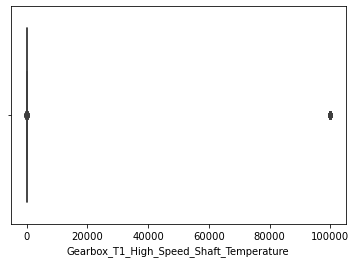

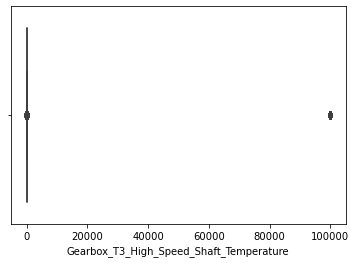

<Figure size 432x288 with 0 Axes>

In [15]:
for i in range(1,3):
    sns.boxplot(data = features, x = features.columns[i])
    plt.figure().show()

In [18]:
features[features["Gearbox_T1_High_Speed_Shaft_Temperature"]>80000]

,Timestamp,Gearbox_T1_High_Speed_Shaft_Temperature,Gearbox_T3_High_Speed_Shaft_Temperature,Gearbox_T1_Intermediate_Speed_Shaft_Temperature,Temperature Gearbox Bearing Hollow Shaft,Tower Acceleration Normal,Gearbox_Oil-2_Temperature,Tower Acceleration Lateral,Temperature Bearing_A,Temperature Trafo-3,...,Blade-2 Set Value_Degree,Pitch Demand Baseline_Degree,Blade-1 Set Value_Degree,Blade-3 Set Value_Degree,Moment Q Direction,Moment Q Filltered,Proxy Sensor_Degree-45,Turbine State,Proxy Sensor_Degree-315,Power(kW)
8478,2019-03-01 00:30:00,99999.0,63.241665,56.393333,60.666668,35.233547,60.443333,25.712807,39.783333,52.526669,...,0.262752,0.000000,0.094833,-0.357584,-66.384140,-66.195198,5.798763,1.0,5.798645,940.041687
8479,2019-03-01 00:40:00,99999.0,62.323334,55.636665,59.884998,47.316895,59.983334,48.373825,37.736668,52.000000,...,0.262752,0.000000,0.094833,-0.357584,-122.402702,-121.719513,5.886084,1.0,5.859026,1024.613281
8480,2019-03-01 00:50:00,99999.0,62.000000,55.000000,59.000000,39.437576,59.000000,32.805084,36.250000,52.000000,...,0.262752,0.000000,0.094833,-0.357584,-130.302368,-130.402664,5.881614,1.0,5.851178,1084.926636
8481,2019-03-01 01:00:00,99999.0,62.000000,54.884998,59.000000,34.113735,59.000000,52.967987,36.000000,52.000000,...,0.262752,0.000000,0.094833,-0.357584,-110.416466,-109.946518,5.794118,1.0,5.772344,1248.613281
8482,2019-03-01 01:10:00,99999.0,62.000000,54.186668,59.000000,40.076042,59.000000,34.795670,36.161667,52.131668,...,0.262752,0.000000,0.094833,-0.357584,-74.179886,-74.173553,5.711793,1.0,5.709113,1269.430054
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153483,2021-12-09 14:10:00,99999.0,68.576668,61.496666,64.805000,106.318451,67.198334,46.831451,52.288334,69.183334,...,4.200825,3.580097,3.658214,2.880676,-46.273819,-44.474995,5.689200,1.0,5.691492,NaN
153484,2021-12-09 14:20:00,99999.0,69.511665,62.263332,66.096664,89.660355,67.826668,44.517891,53.000000,70.388336,...,4.769801,4.142842,4.216659,3.443136,-54.548416,-55.497360,5.706361,1.0,5.704614,NaN
154242,2021-12-14 20:40:00,99999.0,67.538330,60.060001,64.118332,206.664078,64.746666,105.029396,99999.000000,95.000000,...,15.604166,14.993957,15.048667,14.328638,-36.845715,-29.303841,5.742805,1.0,5.745700,NaN
154243,2021-12-14 20:50:00,99999.0,67.346664,60.500000,63.171665,207.614838,65.803337,95.991425,99999.000000,95.000000,...,15.719335,15.106128,15.156605,14.439839,-47.074490,-44.570477,5.744454,1.0,5.743930,NaN


In [17]:
features = features.merge(power, how="left", on = "Timestamp")

<br><br>**First Observations**

<ul>
<li>There are two data table, i.e., features and power. They corresponds to the same time interval. The features table contains some temperature, moment, angle and other technical features. The power table gives the corresponding output. We can concat these tables.</li>
<li>There are 99999 value in each feature, which does not make sense. It is clearly used instead of missing values.&nbsp;</li>
<li>There are 78 columns in our dataframe with more than 150,000 rows. The data size is excessive to perform algorithms with many hyperparameters. We are limited with the computer performance, so, we need to select hyperparameters carefully.</li>
</ul>

<br><br><br>

## 3. Missing Values & Imputation

### 3.1. Missing Analysis

The 99999 value used instead of missing values. To deal with missing values, first we need to assign them as null.

In [19]:
features = features.replace(99999.0,np.nan)

<br><br> We know that temperature cannot be below -250 Celcius-degree. Therefore, we can assign them as null.

In [20]:
temp_cols=[]
for i in range(len(features.columns)):
    if "Temperature" in features.columns[i]:
        temp_cols.append(features.columns[i])

In [21]:
for i in range(len(temp_cols)):
    features[temp_cols[i]] = features[temp_cols[i]].apply(lambda x: np.nan if x<-250 else x)

In [22]:
features.isna().sum()

Timestamp                                              0
Gearbox_T1_High_Speed_Shaft_Temperature             5650
Gearbox_T3_High_Speed_Shaft_Temperature             5796
Gearbox_T1_Intermediate_Speed_Shaft_Temperature     5434
Temperature Gearbox Bearing Hollow Shaft            5077
                                                   ...  
Moment Q Filltered                                  6403
Proxy Sensor_Degree-45                              5291
Turbine State                                       5535
Proxy Sensor_Degree-315                             6115
Power(kW)                                          17532
Length: 78, dtype: int64

<br>**Decision:** We have now our missing values. We can impute them, i.e. fill them using machine learning algotihms.<br><br><br>

### 3.2. Imputers

#### 3.2.1. Simple Imputer

In [23]:
from sklearn.impute import SimpleImputer

In [24]:
imputer = SimpleImputer(strategy='mean')

#### 3.2.2. Iterative Imputer

In [25]:
imputer = IterativeImputer()

#### 3.2.3. LGBM Imputer

**Note:** This Imputer is not in sklearn library. This special work belongs to an engineer on github. <br> Reference: https://github.com/analokmaus/kuma_utils/blob/master/preprocessing/imputer.py

In [26]:
# ref: https://github.com/analokmaus/kuma_utils/blob/master/preprocessing/imputer.py
def analyze_column(input_series: pd.Series) -> str:
    if pd.api.types.is_numeric_dtype(input_series):
        return 'numeric'
    else:
        return 'categorical'
class LGBMImputer:
    '''
    Regression imputer using LightGBM
    '''

    def __init__(self, cat_features=[], n_iter=100, verbose=False):
        self.n_iter = n_iter
        self.cat_features = cat_features
        self.verbose = verbose
        self.n_features = None
        self.feature_names = None
        self.feature_with_missing = None
        self.imputers = {}
        self.offsets = {}
        self.objectives = {}
        
    def fit(self, X, y=None):
        self.n_features = X.shape[1]
        if isinstance(X, pd.DataFrame):
            self.feature_names = X.columns.tolist()
        else:
            self.feature_names = [f'f{i}' for i in range(self.n_features)]
            X = pd.DataFrame(X, columns=self.feature_names)
        self.feature_with_missing = [
            col for col in self.feature_names if X[col].isnull().sum() > 0]

        pbar = tqdm(self.feature_with_missing)
        for icol, col in enumerate(pbar):
            if icol in self.cat_features:
                nuni = X[col].dropna().nunique()
                if nuni == 2:
                    params = {
                        'objective': 'binary'
                    }
                elif nuni > 2:
                    params = {
                        'objective': 'multiclass',
                        'num_class': nuni + 1
                    }
            else:  # automatic analyze column
                if analyze_column(X[col]) == 'numeric':
                    params = {
                        'objective': 'regression'
                    }
                else:
                    nuni = X[col].dropna().nunique()
                    if nuni == 2:
                        params = {
                            'objective': 'binary'
                        }
                    elif nuni > 2:
                        params = {
                            'objective': 'multiclass',
                            'num_class': nuni + 1
                        }
                    else:
                        print(f'column {col} has only one unique value.')
                        continue

            params['verbosity'] = -1

            null_idx = X[col].isnull()
            x_train = X.loc[~null_idx].drop(col, axis=1)
            x_test = X.loc[null_idx].drop(col, axis=1)
            y_offset = X[col].min()
            y_train = X.loc[~null_idx, col].astype(int) - y_offset
            dtrain = lgb.Dataset(
                data=x_train,
                label=y_train
            )

            early_stopping_rounds = int(self.n_iter/10)
            model = lgb.train(
                params, dtrain, valid_sets=[dtrain],
                num_boost_round=self.n_iter,
                early_stopping_rounds=early_stopping_rounds,
                verbose_eval=0,
            )

            self.imputers[col] = model
            self.offsets[col] = y_offset
            self.objectives[col] = params['objective']
            if self.verbose:
                pbar.set_description(
                    f'{col}:\t{self.objectives[col]}...iter{model.best_iteration}/{self.n_iter}')

    def transform(self, X):
        output_X = X.copy()

        for icol, col in enumerate(tqdm(self.feature_with_missing)):
            model = self.imputers[col]
            y_offset = self.offsets[col]
            objective = self.objectives[col]

            null_idx = X[col].isnull()
            x_test = X.loc[null_idx].drop(col, axis=1)

            y_test = model.predict(x_test)
            if objective == 'multiclass':
                y_test = np.argmax(y_test, axis=1).astype(float)
            elif objective == 'binary':
                y_test = (y_test > 0.5).astype(float)
            y_test += y_offset
            output_X.loc[null_idx, col] = y_test
            if objective in ['multiclass', 'binary']:
                output_X[col] = output_X[col].astype(int)

        return output_X
        
    def fit_transform(self, X, y=None):
        self.n_features = X.shape[1]
        if isinstance(X, pd.DataFrame):
            self.feature_names = X.columns.tolist()
        else:
            self.feature_names = [f'f{i}' for i in range(self.n_features)]
            X = pd.DataFrame(X, columns=self.feature_names)

        output_X = X.copy()
        self.feature_with_missing = [col for col in self.feature_names if X[col].isnull().sum() > 0]

        pbar = tqdm(self.feature_with_missing)
        for icol, col in enumerate(pbar):
            if icol in self.cat_features:
                nuni = X[col].dropna().nunique()
                if nuni == 2:
                    params = {
                        'objective': 'binary'
                    }
                elif nuni > 2:
                    params = {
                        'objective': 'multiclass',
                        'num_class': nuni + 1
                    }
            else: # automatic analyze column
                if analyze_column(X[col]) == 'numeric':
                    params = {
                        'objective': 'regression'
                    }
                else:
                    nuni = X[col].dropna().nunique()
                    if nuni == 2:
                        params = {
                            'objective': 'binary'
                        }
                    elif nuni > 2:
                        params = {
                            'objective': 'multiclass',
                            'num_class': nuni + 1
                        }
                    else:
                        print(f'column {col} has only one unique value.')
                        continue
          
            params['verbosity'] = -1
            
            null_idx = X[col].isnull()
            x_train = X.loc[~null_idx].drop(col, axis=1)
            x_test = X.loc[null_idx].drop(col, axis=1)
            y_offset = X[col].min()
            y_train = X.loc[~null_idx, col].astype(int) - y_offset
            dtrain = lgb.Dataset(
                data=x_train,
                label=y_train
            )

            early_stopping_rounds = int(self.n_iter/10)
            model = lgb.train(
                params, dtrain, valid_sets=[dtrain], 
                num_boost_round=self.n_iter,
                early_stopping_rounds=early_stopping_rounds,
                verbose_eval=0,
            )

            y_test = model.predict(x_test)
            if params['objective'] == 'multiclass':
                y_test = np.argmax(y_test, axis=1).astype(float)
            elif params['objective'] == 'binary':
                y_test = (y_test > 0.5).astype(float)
            y_test += y_offset
            output_X.loc[null_idx, col] = y_test
            if params['objective'] in ['multiclass', 'binary']:
                output_X[col] = output_X[col].astype(int)
            self.imputers[col] = model
            self.offsets[col] = y_offset
            self.objectives[col] = params['objective']
            if self.verbose:
                pbar.set_description(f'{col}:\t{self.objectives[col]}...iter{model.best_iteration}/{self.n_iter}')
        
        return output_X

In [27]:
imputer = LGBMImputer(verbose = True)

#### 3.2.4. KNN Imputer

In [28]:
from sklearn.impute import KNNImputer

In [29]:
imputer = KNNImputer()

### 3.3. Imputer Fit_Transform

In [30]:
features["month"] = pd.to_datetime(features["Timestamp"]).dt.month
features["year"] = pd.to_datetime(features["Timestamp"]).dt.year
features["hour"] = pd.to_datetime(features["Timestamp"]).dt.hour
features["week"] = pd.to_datetime(features["Timestamp"]).dt.week

/var/folders/k5/yg__kmls5zndgtyl75h907040000gn/T/ipykernel_861/1814083638.py:4: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  features["week"] = pd.to_datetime(features["Timestamp"]).dt.week


In [442]:
df = features.copy()

In [443]:
df.loc[:, df.columns[1:]] = imputer.fit_transform(df[df.columns[1:]])

  0%|          | 0/77 [00:00<?, ?it/s]/Users/sevdeaydin/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/sevdeaydin/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
Gearbox_T1_High_Speed_Shaft_Temperature:	regression...iter100/100:   1%|▏         | 1/77 [00:03<04:54,  3.87s/it]/Users/sevdeaydin/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early

In [158]:
df.isna().sum()

Timestamp                                              0
Gearbox_T1_High_Speed_Shaft_Temperature                0
Gearbox_T3_High_Speed_Shaft_Temperature                0
Gearbox_T1_Intermediate_Speed_Shaft_Temperature        0
Temperature Gearbox Bearing Hollow Shaft               0
                                                   ...  
Power(kW)                                          17532
month                                                  0
year                                                   0
hour                                                   0
week                                                   0
Length: 82, dtype: int64

In [262]:
#df.to_csv("df_imputed.csv")

In [46]:
#df = pd.read_csv("df_imputed.csv")
#df["Timestamp"] = pd.to_datetime(df["Timestamp"])
#df.drop("Unnamed: 0", axis=1, inplace=True)

<br><br><br>

## 4. ML Setup

### 4.1. Creating X, y

In [341]:
#df = pd.read_csv("train_imputed.csv")

In [48]:
test_mask = pd.to_datetime(df["Timestamp"]) > "2021-08-14 23:50:00"

In [49]:
train_df = df[~test_mask].copy().reset_index(drop=True)
test_df = df[test_mask].copy().reset_index(drop=True)

In [53]:
X = train_df.iloc[:,1:-5]

In [54]:
y = train_df.iloc[:,-5]

<br><br>

### 4.2. Train Test Split

#### 4.2.1. Standart Train Test

In [88]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

In [89]:
y_train.describe()

count    109384.000000
mean       1138.204875
std        1078.629847
min         -48.596668
25%          79.758751
50%         777.932495
75%        2311.387817
max        2779.423340
Name: Power(kW), dtype: float64

In [90]:
y_test.describe()

count    27346.000000
mean      1139.962249
std       1077.598725
min        -46.018333
25%         83.926668
50%        779.507507
75%       2307.064941
max       2777.798340
Name: Power(kW), dtype: float64

#### 4.2.2. StrafiedKFold Train Test 

In [57]:
yint = y.astype("int")

In [58]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1337)
for f, (t_,v_) in enumerate(skf.split(yint,yint)):
    #df.loc[v_, 'kfold'] = f
    df_train = df.loc[t_]
    df_test = df.loc[v_]

/Users/sevdeaydin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


In [59]:
X_train = df_train.iloc[:,1:-5]
X_test = df_test.iloc[:,1:-5]

In [61]:
y_train = df_train.iloc[:,-5]
y_test = df_test.iloc[:,-5]

In [64]:
df.describe()

,Gearbox_T1_High_Speed_Shaft_Temperature,Gearbox_T3_High_Speed_Shaft_Temperature,Gearbox_T1_Intermediate_Speed_Shaft_Temperature,Temperature Gearbox Bearing Hollow Shaft,Tower Acceleration Normal,Gearbox_Oil-2_Temperature,Tower Acceleration Lateral,Temperature Bearing_A,Temperature Trafo-3,Gearbox_T3_Intermediate_Speed_Shaft_Temperature,...,Moment Q Direction,Moment Q Filltered,Proxy Sensor_Degree-45,Turbine State,Proxy Sensor_Degree-315,Power(kW),month,year,hour,week
count,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,...,154262.000000,154262.000000,154262.000000,154262.000000,154262.000000,136730.000000,154262.000000,154262.000000,154262.000000,154262.000000
mean,53.138731,54.987961,49.556883,53.411756,60.797851,53.513904,35.301548,40.157756,61.397071,53.412881,...,-9.195533,-9.138594,5.778420,1.364649,5.800647,1138.556350,6.430994,2019.985123,11.497368,26.241550
std,11.734949,11.877821,9.940680,9.656552,50.874421,11.105216,24.943922,13.313499,14.774867,9.659040,...,53.562679,53.365006,0.106063,0.816662,0.112287,1078.419992,3.400068,0.812821,6.932148,14.846064
min,13.000000,15.013333,14.000000,16.000000,0.000000,13.474475,0.000000,5.000000,13.845000,16.000000,...,-1287.386719,-1286.707886,-0.238800,1.000000,-0.238800,-48.596668,1.000000,2019.000000,0.000000,1.000000
25%,44.000000,46.000000,41.148751,47.000000,24.340785,46.000000,17.460453,29.912084,51.918335,47.000000,...,-35.294100,-35.226508,5.725352,1.000000,5.737255,80.394167,3.000000,2019.000000,5.000000,13.000000
50%,56.998333,58.610001,52.145000,55.000000,49.879589,56.000000,33.002827,39.000000,57.000000,55.000000,...,-10.143938,-10.306726,5.773964,1.000000,5.789509,778.220825,6.000000,2020.000000,11.000000,26.000000
75%,63.000000,65.000000,58.334999,61.365002,82.983734,62.786667,48.492470,49.202918,69.000000,61.368332,...,20.632269,20.580237,5.837952,1.000000,5.875267,2310.443237,9.000000,2021.000000,18.000000,39.000000
max,70.593330,73.000000,65.889999,68.866669,601.405579,70.646667,369.769379,74.000000,124.000000,68.866669,...,1104.722900,1323.434570,6.250977,5.000000,6.231746,2779.423340,12.000000,2021.000000,23.000000,53.000000


In [63]:
df_train.describe()

,Gearbox_T1_High_Speed_Shaft_Temperature,Gearbox_T3_High_Speed_Shaft_Temperature,Gearbox_T1_Intermediate_Speed_Shaft_Temperature,Temperature Gearbox Bearing Hollow Shaft,Tower Acceleration Normal,Gearbox_Oil-2_Temperature,Tower Acceleration Lateral,Temperature Bearing_A,Temperature Trafo-3,Gearbox_T3_Intermediate_Speed_Shaft_Temperature,...,Moment Q Direction,Moment Q Filltered,Proxy Sensor_Degree-45,Turbine State,Proxy Sensor_Degree-315,Power(kW),month,year,hour,week
count,109384.000000,109384.000000,109384.000000,109384.000000,109384.000000,109384.000000,109384.000000,109384.000000,109384.000000,109384.000000,...,109384.000000,109384.000000,109384.000000,109384.000000,109384.000000,109384.000000,109384.000000,109384.000000,109384.000000,109384.000000
mean,52.832520,54.679188,49.270556,53.163956,59.980019,53.238066,34.853626,39.854634,59.682850,53.170340,...,-9.573806,-9.492157,5.781260,1.371571,5.804296,1138.590671,5.981844,2019.854814,11.480491,24.351039
std,11.786488,11.945920,9.989398,9.719577,50.841342,11.163540,24.810206,13.459108,12.764499,9.707490,...,54.378346,54.260672,0.111341,0.817447,0.117213,1078.395313,3.323342,0.772348,6.933125,14.607234
min,13.000000,15.013333,14.000000,16.000000,0.000000,13.474475,0.000000,5.000000,13.845000,16.000000,...,-1287.386719,-1286.707886,-0.238800,1.000000,-0.238800,-48.596668,1.000000,2019.000000,0.000000,1.000000
25%,43.529832,45.591667,41.000000,47.000000,23.565812,45.683334,17.038607,29.000000,51.000000,47.000000,...,-35.712196,-35.554326,5.728754,1.000000,5.741382,80.397915,3.000000,2019.000000,5.000000,12.000000
50%,56.330002,58.000000,52.000000,54.544998,48.860693,55.488335,32.244823,38.011665,56.000000,54.540834,...,-10.371376,-10.496351,5.778066,1.000000,5.794496,778.422485,6.000000,2020.000000,11.000000,23.000000
75%,62.915001,65.000000,58.146667,61.208332,81.552164,62.623333,48.222225,49.000000,67.000000,61.205002,...,20.312794,20.310226,5.840518,1.000000,5.878390,2310.153809,9.000000,2020.000000,18.000000,36.000000
max,70.535004,73.000000,65.889999,68.866669,601.405579,70.646667,299.205963,74.000000,124.000000,68.866669,...,1104.722900,1323.434570,6.250977,5.000000,6.231746,2779.423340,12.000000,2021.000000,23.000000,53.000000


In [65]:
df_test.describe()

,Gearbox_T1_High_Speed_Shaft_Temperature,Gearbox_T3_High_Speed_Shaft_Temperature,Gearbox_T1_Intermediate_Speed_Shaft_Temperature,Temperature Gearbox Bearing Hollow Shaft,Tower Acceleration Normal,Gearbox_Oil-2_Temperature,Tower Acceleration Lateral,Temperature Bearing_A,Temperature Trafo-3,Gearbox_T3_Intermediate_Speed_Shaft_Temperature,...,Moment Q Direction,Moment Q Filltered,Proxy Sensor_Degree-45,Turbine State,Proxy Sensor_Degree-315,Power(kW),month,year,hour,week
count,27346.000000,27346.000000,27346.000000,27346.000000,27346.000000,27346.000000,27346.000000,27346.000000,27346.000000,27346.000000,...,27346.000000,27346.000000,27346.000000,27346.000000,27346.000000,27346.000000,27346.000000,27346.000000,27346.000000,27346.000000
mean,52.800304,54.648334,49.230969,53.127670,60.125176,53.200106,34.872574,39.810415,59.681971,53.130764,...,-9.376173,-9.439669,5.781507,1.373971,5.804700,1138.419064,5.972318,2019.855701,11.571638,24.300739
std,11.785743,11.942268,9.998200,9.715438,50.902649,11.152046,24.870840,13.468623,12.880435,9.715226,...,53.507711,53.313972,0.096780,0.825803,0.103230,1078.538408,3.334544,0.771939,6.935421,14.651126
min,13.000000,16.000000,14.000000,16.995001,0.000000,14.000000,0.000000,5.000000,14.000000,16.995001,...,-1061.604248,-1025.686157,-0.238800,1.000000,-0.238800,-47.343334,1.000000,2019.000000,0.000000,1.000000
25%,43.559584,45.647501,41.000000,47.000000,23.723381,45.625417,16.873823,29.000000,51.000000,47.000000,...,-35.094096,-35.296923,5.728946,1.000000,5.741177,80.326668,3.000000,2019.000000,6.000000,12.000000
50%,56.277500,58.000000,51.976665,54.432500,49.130671,55.424667,32.251411,38.051666,56.000000,54.438334,...,-9.938408,-10.194350,5.777341,1.000000,5.794507,776.669983,6.000000,2020.000000,12.000000,23.000000
75%,62.889999,65.000000,58.138332,61.159583,81.483984,62.605000,48.070621,49.000000,66.984583,61.143333,...,20.675529,20.573827,5.840292,1.000000,5.878551,2310.753235,9.000000,2020.000000,18.000000,36.000000
max,70.593330,72.843330,65.828331,68.463333,399.259979,70.639999,228.011688,74.000000,124.000000,68.463333,...,773.534729,772.748047,6.239525,5.000000,6.198403,2777.798340,12.000000,2021.000000,23.000000,53.000000


**Observation:** StratifiedKFold keeps the distribution of the data when splitting them as train and test.

<br><br>

### 4.3. Scaler

Some Regression Algorithms requires the data to be scaled. Tree based algorithms can work with the original data values, however, it will not harm to use scaled data in tree based algorithms.

In [66]:
scaler = StandardScaler()

In [67]:
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

<br><br>

## 5. Regression Models

### 5.1. ElasticNET

In [176]:
from sklearn.linear_model import ElasticNet

In [178]:
elastic_model = ElasticNet()

In [179]:
elastic_model.fit(scaled_X_train,y_train)

ElasticNet()

In [180]:
y_pred = elastic_model.predict(scaled_X_test)

In [182]:
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import ElasticNet

In [183]:
np.sqrt(mean_squared_error(y_test, y_pred))

344.3159188371857

In [190]:
from sklearn.model_selection import GridSearchCV

In [212]:
param_grid = {"alpha":[0.001,0.01,0.1,0.5,1.0,2.0],
              "l1_ratio":[0.1,0.5,1.0,2.0]}

In [213]:
grid_elastic_model = GridSearchCV(elastic_model,param_grid, scoring = "neg_mean_squared_error")

In [214]:
grid_elastic_model.fit(scaled_X_train,y_train)

/Users/sevdeaydin/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.563e+09, tolerance: 1.017e+07
  model = cd_fast.enet_coordinate_descent(
/Users/sevdeaydin/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.586e+09, tolerance: 1.017e+07
  model = cd_fast.enet_coordinate_descent(
/Users/sevdeaydin/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasi

GridSearchCV(estimator=ElasticNet(),
             param_grid={'alpha': [0.001, 0.01, 0.1, 0.5, 1.0, 2.0],
                         'l1_ratio': [0.1, 0.5, 1.0, 2.0]},
             scoring='neg_mean_squared_error')

In [216]:
grid_elastic_model.best_estimator_

ElasticNet(alpha=0.001)

In [217]:
y_pred = grid_elastic_model.predict(scaled_X_test)

In [218]:
np.sqrt(mean_squared_error(y_test, y_pred))

241.03954812379715

### 5.2. KNN Regressor

In [221]:
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor

In [222]:
knr_model = KNeighborsRegressor()

In [224]:
knr_model.fit(scaled_X_train,y_train)

KNeighborsRegressor()

In [228]:
y_pred = knr_model.predict(scaled_X_test)

In [229]:
np.sqrt(mean_squared_error(y_test, y_pred))

144.87005207925768

In [232]:
param_grid = {"n_neighbors":[2,5,10],
              "weights":['uniform','distance'],
              "leaf_size":[10,30,50],
              "p":[1,2]}

In [233]:
grid_knr_model = GridSearchCV(knr_model,param_grid, scoring = "neg_mean_squared_error")

In [234]:
grid_knr_model.fit(scaled_X_train,y_train)

GridSearchCV(estimator=KNeighborsRegressor(),
             param_grid={'leaf_size': [10, 30, 50], 'n_neighbors': [2, 5, 10],
                         'p': [1, 2], 'weights': ['uniform', 'distance']},
             scoring='neg_mean_squared_error')

In [236]:
grid_knr_model.best_params_

{'leaf_size': 10, 'n_neighbors': 5, 'p': 1, 'weights': 'distance'}

In [237]:
y_pred = grid_knr_model.predict(scaled_X_test)

In [238]:
np.sqrt(mean_squared_error(y_test, y_pred))

111.983800973887

### 5.3. SVM

In [239]:
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

In [240]:
svr_model = SVR()

In [242]:
svr_model.fit(scaled_X_train, y_train)

SVR()

In [243]:
y_pred = svr_model.predict(scaled_X_test)

In [244]:
np.sqrt(mean_squared_error(y_test, y_pred))

239.33892447629214

In [246]:
param_grid = {"kernel":['linear', 'poly', 'rbf', 'sigmoid', 'precomputed'],
    "degree":[2,3,4],
    "gamma":['scale','auto'],
    "C":[0.1,1.0,10.0],
    "epsilon":[0.01,0.1,1]}

In [247]:
grid_svr_model = GridSearchCV(svr_model,param_grid, scoring = "neg_mean_squared_error")

In [248]:
# Takes too long
grid_svr_model.fit(scaled_X_train,y_train)

KeyboardInterrupt: 

In [251]:
grid_svr_model.best_params_

AttributeError: 'GridSearchCV' object has no attribute 'best_params_'

In [237]:
y_pred = grid_svr_model.predict(scaled_X_test)

In [252]:
#np.sqrt(mean_squared_error(y_test, y_pred))

### 5.4. Neural Network (MLP Regressor)

In [253]:
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

In [254]:
mlp_model = MLPRegressor()

In [255]:
mlp_model.fit(scaled_X_train, y_train)

/Users/sevdeaydin/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPRegressor()

In [256]:
y_pred = mlp_model.predict(scaled_X_test)

In [257]:
np.sqrt(mean_squared_error(y_test, y_pred))

2598.478042914616

In [259]:
param_grid = {'hidden_layer_sizes':[(100,),(100,50,100),(100,100,100,100),(300,100,50)], 
              'alpha':[0.001,0.0001,0.00001], 
              'learning_rate':['constant','adaptive'],
              'max_iter':[200,400]
             }

In [260]:
grid_mlp_model = GridSearchCV(mlp_model,param_grid, scoring = "neg_mean_squared_error")

In [ ]:
#grid_mlp_model.fit(scaled_X_train,y_train)

In [ ]:
grid_mlp_model.best_params_

In [237]:
y_pred = grid_mlp_model.predict(scaled_X_test)

In [263]:
#np.sqrt(mean_squared_error(y_test, y_pred))

### 5.5. DecisionTreeRegressor

In [264]:
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor

In [265]:
dtr_model = DecisionTreeRegressor()

In [266]:
dtr_model.fit(scaled_X_train, y_train)

DecisionTreeRegressor()

In [267]:
y_pred = dtr_model.predict(scaled_X_test)

In [268]:
np.sqrt(mean_squared_error(y_test, y_pred))

58.54165085429906

In [269]:
param_grid = {"min_samples_split":range(2,100,10), 
              "max_leaf_nodes":range(2,10,3)
             }

In [270]:
grid_dtr_model = GridSearchCV(dtr_model,param_grid, scoring = "neg_mean_squared_error")

In [271]:
grid_dtr_model.fit(scaled_X_train,y_train)

GridSearchCV(estimator=DecisionTreeRegressor(),
             param_grid={'max_leaf_nodes': range(2, 10, 3),
                         'min_samples_split': range(2, 100, 10)},
             scoring='neg_mean_squared_error')

In [272]:
grid_dtr_model.best_params_

{'max_leaf_nodes': 8, 'min_samples_split': 2}

In [273]:
y_pred = grid_dtr_model.predict(scaled_X_test)

In [274]:
np.sqrt(mean_squared_error(y_test, y_pred))

136.1467431880056

### 5.6. Bagging Regressor

In [275]:
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor

In [276]:
br_model = BaggingRegressor(bootstrap_features = True)

In [277]:
br_model.fit(scaled_X_train, y_train)

BaggingRegressor(bootstrap_features=True)

In [278]:
y_pred = br_model.predict(scaled_X_test)

In [279]:
np.sqrt(mean_squared_error(y_test, y_pred))

45.97117733303041

In [259]:
param_grid = {"n_estimators":[5,10,15]
             }

In [260]:
grid_br_model = GridSearchCV(br_model,param_grid, scoring = "neg_mean_squared_error")

In [280]:
grid_br_model.fit(scaled_X_train,y_train)

In [ ]:
grid_br_model.best_params_

In [ ]:
y_pred = grid_br_model.predict(scaled_X_test)

In [ ]:
np.sqrt(mean_squared_error(y_test, y_pred))

### 5.7. RandomForestRegressor

In [281]:
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor

In [282]:
rf_model = RandomForestRegressor()

In [283]:
rf_model.fit(scaled_X_train, y_train)

RandomForestRegressor()

In [284]:
y_pred = rf_model.predict(scaled_X_test)

In [285]:
np.sqrt(mean_squared_error(y_test, y_pred))

42.689322008756896

In [ ]:
param_grid = {"n_estimators":[500,1000],  
              "max_features":[10,50,70]
             }

In [ ]:
grid_rf_model = GridSearchCV(rf_model,param_grid, scoring = "neg_mean_squared_error")

In [ ]:
grid_rf_model.fit(scaled_X_train,y_train)

In [ ]:
grid_rf_model.best_params_

In [ ]:
y_pred = grid_rf_model.predict(scaled_X_test)

In [ ]:
np.sqrt(mean_squared_error(y_test, y_pred))

### 5.8. AdaBoost Regressor

In [286]:
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, AdaBoostRegressor

In [287]:
ada_model = AdaBoostRegressor()

In [288]:
ada_model.fit(scaled_X_train, y_train)

AdaBoostRegressor()

In [289]:
y_pred = ada_model.predict(scaled_X_test)

In [290]:
np.sqrt(mean_squared_error(y_test, y_pred))

179.40520437614256

In [ ]:
param_grid = {"learning_rate":[0.01,0.02,0.1], 
              "n_estimators":[100,1000,7000], 
              "subsample":[0.9,1.0]
              }

In [ ]:
grid_ada_model = GridSearchCV(ada_model,param_grid, scoring = "neg_mean_squared_error")

In [ ]:
grid_ada_model.fit(scaled_X_train,y_train)

In [ ]:
grid_ada_model.best_params_

In [ ]:
y_pred = grid_ada_model.predict(scaled_X_test)

In [ ]:
np.sqrt(mean_squared_error(y_test, y_pred))

### 5.9. GradientBoostingRegressor

In [291]:
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor

In [292]:
gb_model = GradientBoostingRegressor()

In [293]:
gb_model.fit(scaled_X_train, y_train)

GradientBoostingRegressor()

In [294]:
y_pred = gb_model.predict(scaled_X_test)

In [295]:
np.sqrt(mean_squared_error(y_test, y_pred))

45.68627684868939

In [ ]:
param_grid = {"learning_rate":[0.01,0.02,0.1], 
              "n_estimators":[100,1000,7000], 
              "subsample":[0.9,1.0]
              }

In [ ]:
grid_gb_model = GridSearchCV(gb_model,param_grid, scoring = "neg_mean_squared_error")

In [ ]:
grid_gb_model.fit(scaled_X_train,y_train)

In [ ]:
grid_gb_model.best_params_

In [ ]:
y_pred = grid_gb_model.predict(scaled_X_test)

In [ ]:
np.sqrt(mean_squared_error(y_test, y_pred))

### 5.10. XGBoost

In [297]:
#pip install xgboost

     |████████████████████████████████| 1.7 MB 1.4 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [298]:
import xgboost as xgb

In [300]:
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

In [301]:
xgb_model = XGBRegressor()

In [314]:
xgb_model.fit(scaled_X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [315]:
y_pred = xgb_model.predict(scaled_X_test)

In [316]:
np.sqrt(mean_squared_error(y_test, y_pred))

36.191649367264546

In [ ]:
param_grid = {"learning_rate":[0.01,0.02,0.1], 
              "n_estimators":[100,1000,7000],
              "colsample_bytree": [0.9,1]
              }

In [ ]:
grid_xgb_model = GridSearchCV(xgb_model,param_grid, scoring = "neg_mean_squared_error")

In [ ]:
grid_xgb_model.fit(scaled_X_train,y_train)

In [ ]:
grid_xgb_model.best_params_

In [ ]:
y_pred = grid_xgb_model.predict(scaled_X_test)

In [ ]:
np.sqrt(mean_squared_error(y_test, y_pred))

### 5.11. LGBM Regressor

In [369]:
lgbm_model = LGBMRegressor()

In [448]:
lgbm_model.fit(X_train, y_train)

LGBMRegressor()

In [449]:
y_pred = lgbm_model.predict(X_test)

In [450]:
np.sqrt(mean_squared_error(y_test, y_pred))

22.663137590940956

In [169]:
np.sqrt(mean_squared_error(y_test, y_pred))

22.92361900161651

In [23]:
param_grid = {"learning_rate":[0.01,0.02,0.1], 
              "n_estimators":[100,1000], 
              "subsample":[0.9,1.0]
              }

In [24]:
grid_lgbm_model = GridSearchCV(lgbm_model,param_grid, scoring = "neg_mean_squared_error",verbose=2)

In [26]:
grid_lgbm_model.fit(X_train,y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END learning_rate=0.01, n_estimators=100, subsample=0.9; total time=   2.5s
[CV] END learning_rate=0.01, n_estimators=100, subsample=0.9; total time=   1.8s
[CV] END learning_rate=0.01, n_estimators=100, subsample=0.9; total time=   1.4s
[CV] END learning_rate=0.01, n_estimators=100, subsample=0.9; total time=   1.7s
[CV] END learning_rate=0.01, n_estimators=100, subsample=0.9; total time=   2.1s
[CV] END learning_rate=0.01, n_estimators=100, subsample=1.0; total time=   1.9s
[CV] END learning_rate=0.01, n_estimators=100, subsample=1.0; total time=   1.7s
[CV] END learning_rate=0.01, n_estimators=100, subsample=1.0; total time=   1.6s
[CV] END learning_rate=0.01, n_estimators=100, subsample=1.0; total time=   1.5s
[CV] END learning_rate=0.01, n_estimators=100, subsample=1.0; total time=   1.9s
[CV] END learning_rate=0.01, n_estimators=1000, subsample=0.9; total time=  11.5s
[CV] END learning_rate=0.01, n_estimators=1000,

KeyboardInterrupt: 

In [19]:
grid_lgbm_model.best_params_

{'learning_rate': 0.1, 'n_estimators': 100, 'subsample': 0.9}

In [ ]:
y_pred = grid_lgbm_model.predict(scaled_X_test)

In [ ]:
np.sqrt(mean_squared_error(y_test, y_pred))

In [342]:
lgb_params = {
    "learning_rate": 0.02,
    "num_leaves": 64,
    "colsample_bytree": 0.9,
    "subsample": 0.9,
    "verbosity": -1,
    "n_estimators": 7000,
    "early_stopping_rounds": 50,
    "random_state": 42,
    "objective": "regression",
    "metric": "rmse"
}

In [174]:
lgbm_model_2 = LGBMRegressor(learning_rate= 0.02,
    num_leaves= 64,
    colsample_bytree= 0.9,
    subsample= 0.9,
    verbosity= -1,
    n_estimators= 700,
    random_state= 42,
    objective= "regression",
    metric= "rmse")

In [175]:
lgbm_model_2.fit(X_train,y_train)

LGBMRegressor(colsample_bytree=0.9, learning_rate=0.02, metric='rmse',
              n_estimators=700, num_leaves=64, objective='regression',
              random_state=42, subsample=0.9, verbosity=-1)

In [176]:
y_pred = lgbm_model_2.predict(X_test)

In [177]:
np.sqrt(mean_squared_error(y_test, y_pred))

22.651426393759014

### 5.12. CatBoost Regressor

In [455]:
catb_model = CatBoostRegressor(iterations=5000, learning_rate=0.03)

In [456]:
catb_model.fit(X_train, y_train)

0:	learn: 1046.9347394	total: 40.6ms	remaining: 3m 23s
1:	learn: 1016.8167334	total: 59.4ms	remaining: 2m 28s
2:	learn: 987.2229435	total: 77.1ms	remaining: 2m 8s
3:	learn: 958.6214639	total: 94.7ms	remaining: 1m 58s
4:	learn: 930.6728772	total: 111ms	remaining: 1m 50s
5:	learn: 904.1112406	total: 125ms	remaining: 1m 44s
6:	learn: 877.7334859	total: 140ms	remaining: 1m 40s
7:	learn: 852.4066259	total: 156ms	remaining: 1m 37s
8:	learn: 827.9837351	total: 170ms	remaining: 1m 34s
9:	learn: 804.0123014	total: 185ms	remaining: 1m 32s
10:	learn: 780.6570150	total: 203ms	remaining: 1m 32s
11:	learn: 758.3942288	total: 220ms	remaining: 1m 31s
12:	learn: 736.4519258	total: 236ms	remaining: 1m 30s
13:	learn: 714.9846884	total: 252ms	remaining: 1m 29s
14:	learn: 694.3042672	total: 267ms	remaining: 1m 28s
15:	learn: 674.0360727	total: 282ms	remaining: 1m 27s
16:	learn: 654.2771600	total: 297ms	remaining: 1m 26s
17:	learn: 635.3856437	total: 311ms	remaining: 1m 26s
18:	learn: 617.1714431	total: 325

In [457]:
y_pred = catb_model.predict(X_test)

In [458]:
np.sqrt(mean_squared_error(y_test, y_pred))

16.853906225411905

In [211]:
param_grid = {"learning_rate":[0.03], 
              "iterations":[1000,7000]
              }

In [213]:
grid_catb_model = GridSearchCV(catb_model,param_grid, scoring = "neg_mean_squared_error", verbose=2)

In [214]:
grid_catb_model.fit(X_train,y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
0:	learn: 1054.2251029	total: 35.1ms	remaining: 35s
1:	learn: 1023.6058823	total: 48.3ms	remaining: 24.1s
2:	learn: 993.9559304	total: 60.2ms	remaining: 20s
3:	learn: 965.1125092	total: 73.8ms	remaining: 18.4s
4:	learn: 937.1548639	total: 88.9ms	remaining: 17.7s
5:	learn: 910.2286548	total: 104ms	remaining: 17.2s
6:	learn: 883.6070786	total: 118ms	remaining: 16.8s
7:	learn: 857.7921131	total: 133ms	remaining: 16.5s
8:	learn: 833.0181288	total: 147ms	remaining: 16.2s
9:	learn: 809.1797917	total: 162ms	remaining: 16.1s
10:	learn: 785.8375284	total: 175ms	remaining: 15.7s
11:	learn: 763.1390846	total: 187ms	remaining: 15.4s
12:	learn: 740.9271884	total: 199ms	remaining: 15.1s
13:	learn: 719.6859689	total: 211ms	remaining: 14.8s
14:	learn: 698.9514553	total: 223ms	remaining: 14.7s
15:	learn: 678.7909725	total: 235ms	remaining: 14.4s
16:	learn: 659.3670192	total: 248ms	remaining: 14.3s
17:	learn: 640.3516929	total: 261ms	remaining:

GridSearchCV(estimator=<catboost.core.CatBoostRegressor object at 0x7fdbefa8f520>,
             param_grid={'iterations': [1000, 7000], 'learning_rate': [0.03]},
             scoring='neg_mean_squared_error', verbose=2)

In [204]:
pd.DataFrame(grid_catb_model.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_iterations,param_learning_rate,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.780934,0.210200,0.020362,0.018281,100,0.01,"{'iterations': 100, 'learning_rate': 0.01}",-158594.332632,-179690.105075,-170349.511440,-176464.135100,-164151.131088,-169849.843067,7745.852017,5
1,1.546454,0.070940,0.008049,0.001021,100,0.02,"{'iterations': 100, 'learning_rate': 0.02}",-24000.313724,-26940.425131,-26834.023795,-26996.970250,-24669.299356,-25888.206451,1286.931639,4
2,1.437474,0.055811,0.006659,0.000788,100,0.03,"{'iterations': 100, 'learning_rate': 0.03}",-4780.598650,-5175.740929,-5819.274155,-5397.738149,-4371.630303,-5108.996437,498.773488,3
3,1.479219,0.065292,0.009424,0.001961,100,0.04,"{'iterations': 100, 'learning_rate': 0.04}",-1972.148477,-1905.602525,-2572.822947,-2049.392692,-1611.562952,-2022.305919,312.617315,2
4,1.636004,0.156018,0.009156,0.002956,100,0.05,"{'iterations': 100, 'learning_rate': 0.05}",-1569.973334,-1467.514934,-2029.070881,-1459.279624,-1147.662174,-1534.700189,284.832274,1


<AxesSubplot:xlabel='param_iterations', ylabel='mean_test_score'>

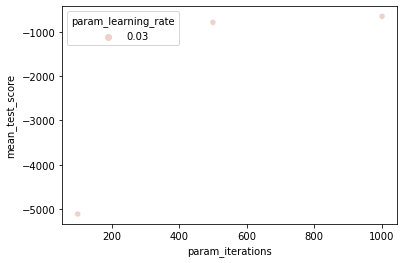

In [212]:
sns.scatterplot(data =pd.DataFrame(grid_catb_model.cv_results_), x = "param_iterations", y="mean_test_score", hue="param_learning_rate")

<AxesSubplot:xlabel='param_iterations', ylabel='mean_test_score'>

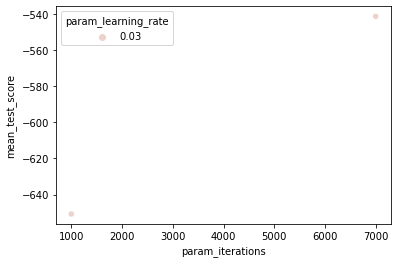

In [215]:
sns.scatterplot(data =pd.DataFrame(grid_catb_model.cv_results_), x = "param_iterations", y="mean_test_score", hue="param_learning_rate")

In [338]:
grid_catb_model.best_params_

{'iterations': 7000, 'learning_rate': 0.02}

In [339]:
y_pred = grid_catb_model.predict(scaled_X_test)

In [340]:
np.sqrt(mean_squared_error(y_test, y_pred))

30.996988515738266

<br><br><br>

## 6. Results and Conclusion

**Results:**

The RMSE score of the ML algorithms are as follows:

<ul>
<li>KNN 144</li>
<li>Elastic 344</li>
<li>SVM 239</li>
<li>MLP(Neural) 2598</li>
<li>DecisionTree 58/136</li>
<li>Bagging 46</li>
<li>RandomForest 42</li>
<li>AdaBoost 179</li>
<li>GradientBoost 45</li>
<li>XGBoost 36</li>
<li>LGBM 22</li>
<li>CatBoost 17</li>
</ul>

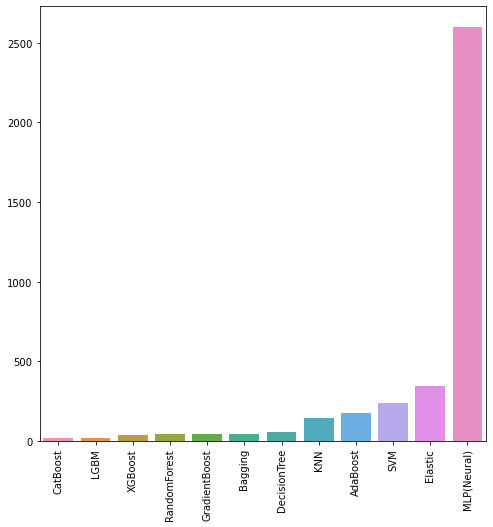

In [92]:
plt.figure(figsize=(8,8))
sns.barplot(x = list(results.index), y = results.values)
plt.xticks(rotation = 90);

<br><br><br>

**Conclusion and Discussion**

<li>The results show that Catboost and LGBM algorithms performing better than the others. Therefore, I used GridSearchCV to tune the especially those model.
<li> Some algorithms like MLP Regressor and SVM needed too much time to perform. Using a computer with M1 processor and 8 Gb RAM, I couldn't finalize GridSearchCV process. Their first scores were very poor anyway, so I did not bother to test them on a cloud system.
<li> After tuning process, the winner algorithm is CatBoost, but LGBM results was very close. Therefore, a better model tuning may change the winner. The best score of this work was the 3rd best score of the competition.